<a href="https://colab.research.google.com/github/SatyaanikaPandam/Data-Science/blob/main/Saty_PandUnit8Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 8 Project: Writing a BARTical


For my Unit 8 Project, I looked at how people interact with Facebook posts by using a BART model. The dataset included the number of likes, comments, and shares each post got, and my goal was to predict the total number of interactions. I wanted to figure out which types of engagement had the biggest impact on how popular a post was. I used BART because it can find patterns in data even when those patterns aren’t super obvious or straight lines.

In [1]:
!pip install pymc-bart
!pip install preliz

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import preliz as pz
import seaborn as sns

In [3]:
url = "https://raw.githubusercontent.com/SatyaanikaPandam/Data-Science/refs/heads/main/dataset_Facebook.csv"

In [4]:
fb = pd.read_csv(url).dropna()

In [5]:
X = fb[['comment',
              'like',
              'share',
]]
Y = fb["Total Interactions"].to_numpy()

<Axes: xlabel='comment', ylabel='Total Interactions'>

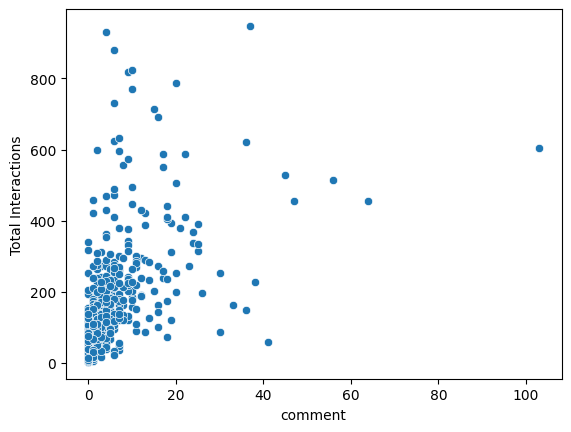

In [6]:
sns.scatterplot(data = fb, y = 'Total Interactions', x = 'comment')

The dots are spread out with a slight upward trend because more comments usually lead to more interactions, but not always. Some posts may get a lot of interactions even with fewer comments, which is why the points don’t form a perfect line.



<Axes: xlabel='like', ylabel='Total Interactions'>

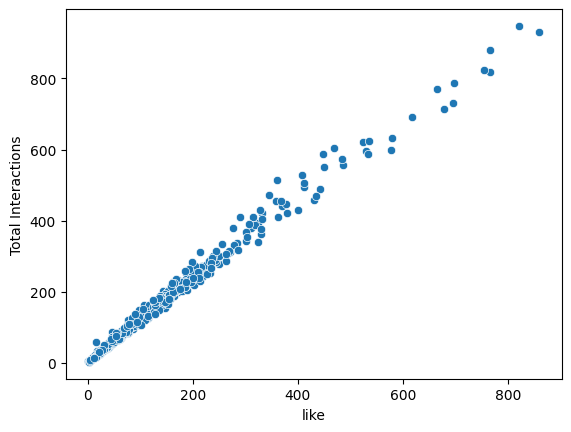

In [7]:
sns.scatterplot(data = fb, y = 'Total Interactions', x = 'like')

This graph shows a clearer upward trend because likes are the most common type of interaction, so more likes usually mean more total engagement. The points are more tightly grouped because likes have a stronger and more consistent relationship with interactions.



<Axes: xlabel='share', ylabel='Total Interactions'>

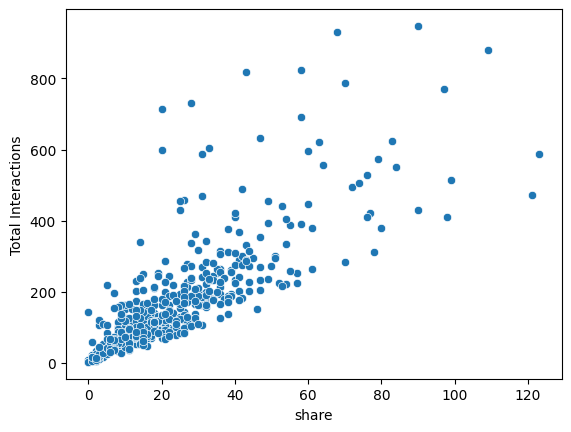

In [8]:
sns.scatterplot(data = fb, y = 'Total Interactions', x = 'share')

The dots are more scattered because shares happen less often and don’t always lead to a lot of other interactions. Some posts with just a few shares might still get high interaction counts from likes or comments, which makes the trend weaker.



In [9]:
# Inspect data statistics
print(fb[['comment', 'like', 'share', 'Total Interactions']].describe())

# Check for problematic values
print(fb[(fb['comment'] <= 0) | (fb['like'] <= 0) | (fb['share'] <= 0) | (fb['Total Interactions'] <= 0)])

          comment        like       share  Total Interactions
count  474.000000  474.000000  474.000000          474.000000
mean     5.727848  143.924051   23.943038          173.594937
std      9.139498  137.249031   19.692964          156.563169
min      0.000000    1.000000    0.000000            2.000000
25%      1.000000   58.250000   11.000000           73.000000
50%      3.000000  101.000000   19.000000          124.500000
75%      7.000000  185.750000   32.000000          224.750000
max    103.000000  859.000000  123.000000          948.000000
     Page total likes    Type  Category  Post Month  Post Weekday  Post Hour  \
2              139441   Photo         3          12             3          3   
6              139441   Photo         3          12             7          9   
7              139441  Status         2          12             7          3   
9              139441  Status         2          12             5         10   
10             139441   Photo         2   

I had to include the code above because the describe() gives a summary of the numbers for comments, likes, shares, and total interactions — like the average, min, max, etc., to understand how the data looks overall. The second part checks if there are any weird or problematic values (like 0 or negative numbers), which could mess up the model or graphs.

In [10]:

with pm.Model() as model_facebook:
    s = pm.HalfNormal('s', 20)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ", pm.math.exp(μ_))
    y = pm.Gamma("y", mu=μ, sigma=s, observed=Y)
    idata_facebook = pm.sample(compute_convergence_checks=False)


Output()

Output()

<Axes: xlabel='y'>

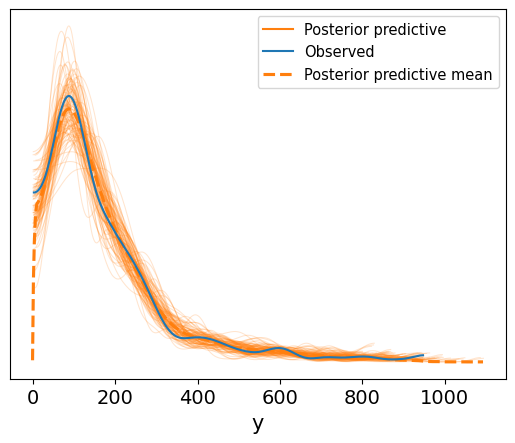

In [11]:
#generate the posterior predictive dist
pm.sample_posterior_predictive(idata_facebook,model_facebook, extend_inferencedata=True)
az.plot_ppc(idata_facebook, num_pp_samples=100, colors=["C1", "C0", "C1"])

This graph compares the actual Facebook interaction data to what the BART model predicted. The model's predictions are closely aligned with the real data, which means the model learned the patterns in the data really well. The reason they line up so nicely is because features like likes and comments have a strong, consistent relationship with total interactions, so the model is able to make very accurate predictions across most posts.

In [12]:

posterior_mean = idata_facebook.posterior["μ"]

μ_hdi = az.hdi(ary=idata_facebook, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_facebook, group="posterior_predictive", var_names=["y"]
).T

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


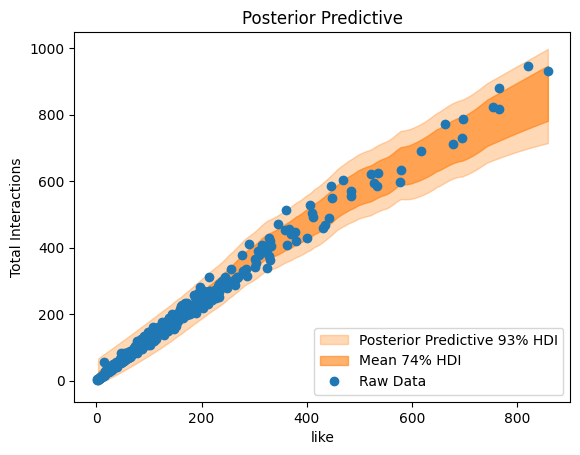

In [13]:
idx = np.argsort(X.iloc[:, 1].to_numpy()) # convert the pandas series to a numpy array for indexing
fig, ax = plt.subplots()

az.plot_hdi(
    x=X.iloc[:, 1].to_numpy(), # convert the pandas series to a numpy array for indexing
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive 93% HDI"},
)

az.plot_hdi(
    x=X.iloc[:, 1].to_numpy(), # convert the pandas series to a numpy array for indexing
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean 74% HDI"},
)
ax.plot(fb["like"], fb["Total Interactions"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="like",
    ylabel="Total Interactions",
);

This creates a graph that shows how well the BART model predicts total interactions based on the number of likes, using HDI bands. The two shaded regions (one wider:93% HDI and one narrower:74% HDI)show where most of the models predictions fall, with the raw data points. The graph looks smooth and layred because the "like " variable has a strong and steady relationship with total interactions, allowing the model to create confident prediction ranges that closely follow the curve of the actual data.

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


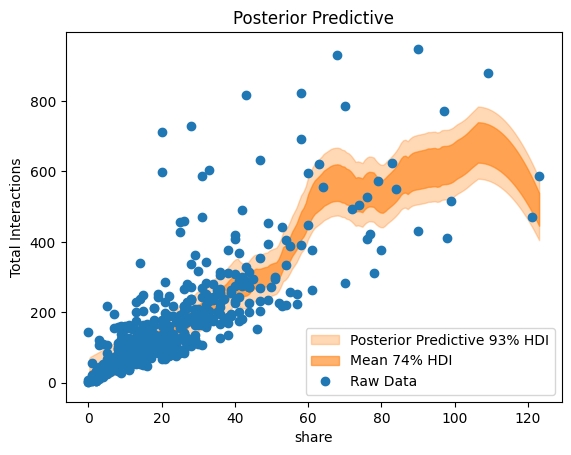

In [14]:
idx = np.argsort(X.iloc[:, 2].to_numpy()) # convert the pandas series to a numpy array for indexing
fig, ax = plt.subplots()

az.plot_hdi(
    x=X.iloc[:, 2].to_numpy(), # convert the pandas series to a numpy array for indexing
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive 93% HDI"},
)

az.plot_hdi(
    x=X.iloc[:, 2].to_numpy(), # convert the pandas series to a numpy array for indexing
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean 74% HDI"},
)
ax.plot(fb["share"], fb["Total Interactions"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="share",
    ylabel="Total Interactions",
);

This makes a similar HDI graph, but this time it shows how the BART model predicts total interactions based on the number of shares. The HDI bands (93% and 74%) are wider and less tightly wraped around the data points, which means the model is less certain about its predictions when using shares alone. The graph looks this way because "share" isnt as strongly or consistently related to total interactions as "like" was, so the model allows more flexibility in its predction range to handle that uncertainty.

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


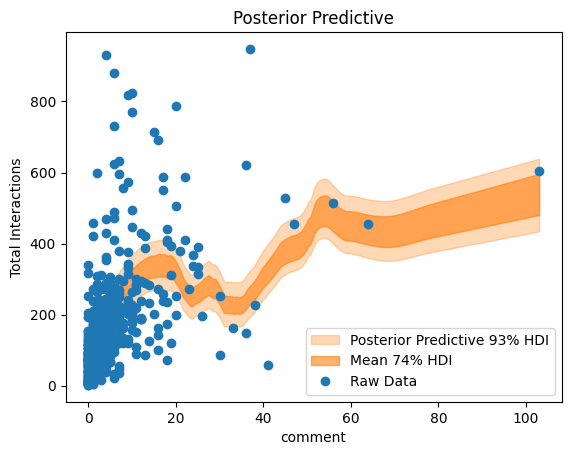

In [15]:
idx = np.argsort(X.iloc[:, 0].to_numpy()) # convert the pandas series to a numpy array for indexing
fig, ax = plt.subplots()

az.plot_hdi(
    x=X.iloc[:, 0].to_numpy(), # convert the pandas series to a numpy array for indexing
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive 93% HDI"},
)

az.plot_hdi(
    x=X.iloc[:, 0].to_numpy(), # convert the pandas series to a numpy array for indexing
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean 74% HDI"},
)
ax.plot(fb["comment"], fb["Total Interactions"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="comment",
    ylabel="Total Interactions",
);

This generates an HDI graph showing how well the BART model predicts total interactiions based on the number of comments. The prediction bands (93% and 74%) are somewhat wide but still follow the general shape of the raw data points, meaning the model sees a moderate conection between comments and overall engagement. The graph looks like this because "comment" has a mixed pattern, it sometimes predicts interactions well, but not always consistently, so the model reflects that uncertainty with broader shaded regions.

array([<Axes: xlabel='comment'>, <Axes: xlabel='like'>,
       <Axes: xlabel='share'>], dtype=object)

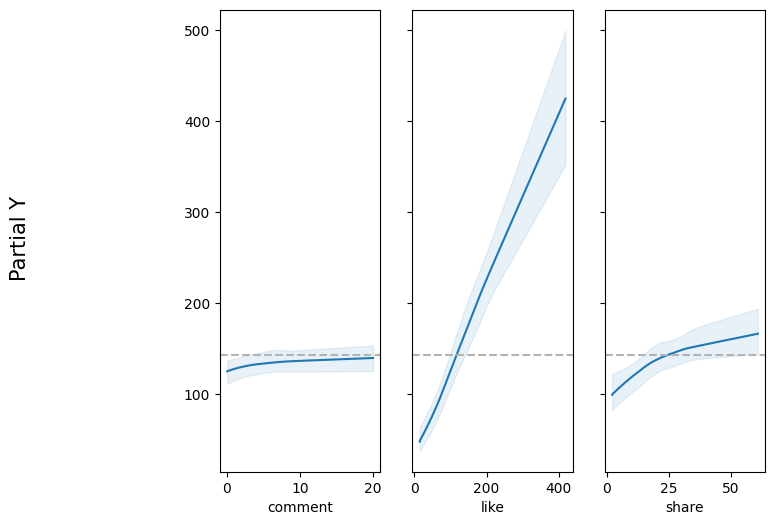

In [16]:
# prompt: do this code for my data set:pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize=(12, 6))


array([<Axes: xlabel='comment'>, <Axes: xlabel='like'>,
       <Axes: xlabel='share'>], dtype=object)

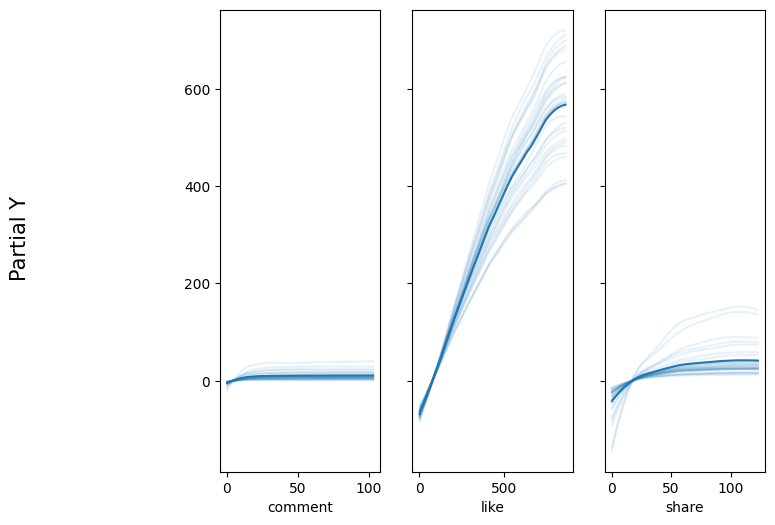

In [17]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

In the ICE plot, the panel for comments shows a moderate fan out and an inconsistent effect on total interactions. Some posts gain a lot from aditional comments, while others barely change, leading to some variation in the prediction lines. The pannel for likes fans out the most, since likes are the strongest and most reliable predictor in the dataset; most lines rise sharply, showing that as likes increase, total interactions tend to go up signifcantly, though the exact impact still varies from post to post. In contrast, the panel for shares fans out the least because shares dont consitently lead to higher engaement, many lines remain flat or only rise slightly, sugesting the model sees shares as a weaker and less reliable driver of total interactions. The model shows the factors driving social media engagement. The results indicated that likes and comments were the strongest predictors of total interactions.